## Dataset Setup
#### In this notebook the original TUPAC Dataset is processed in order to obtain a subset of mitotic figures and hard negative instances using a baseline classifier

In [25]:
import sys
import keras

sys.version
print(sys.version_info)
print(keras.__version__) #with tensorflow backend 


sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
2.2.0


In [1]:
from keras.applications.densenet import DenseNet121
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras import activations, Model
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconvolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Activation 
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import *
from matplotlib.pyplot import imread
import random
from os.path import join, basename, dirname, exists  
import os  
import glob
import numpy as np
import csv
import matplotlib.pyplot as plt
from PIL import * 
from utils.utils_patches import * 

/home/sebastian/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_tupac1 = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/'
path_tupac2 = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_2/'
path_tupac3 = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_3/'
PREFIX_IMGS = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_'
PATH_GT = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/'
list_tifs = glob.glob(path_tupac1 + '**/*.tif') +glob.glob(path_tupac2 + '**/*.tif')+glob.glob(path_tupac3 + '**/*.tif')
list_csv = glob.glob(PATH_GT + '**/*.csv')
print(len(list_tifs))
print(len(list_csv))
list_csv
positive_cases = []
for item in list_csv:
    num_case = int(item.split('/')[-2])
    #print(num_case)
    if num_case in range(24):
        positive_cases.append(item)
len(positive_cases)

dict_case_mitosis = d={i:[] for i in list(1+np.arange(23))}
for item in positive_cases:
    with open(item, 'rt', encoding='utf8') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        num_case = int(item.split('/')[-2])
        if num_case in dict_case_mitosis.keys():
            for row in spamreader:
                dict_case_mitosis[num_case].append(row)
        else:
            dict_case_mitosis[num_case] = []
            for row in spamreader:
                dict_case_mitosis[num_case].append(row)

total_sum = 0
all_names = []
all_lengths = []
for key in dict_case_mitosis.keys():
    total_sum+=len(dict_case_mitosis[key])
    all_names.append(key)
    all_lengths.append(len(dict_case_mitosis[key]))
    #print(len(dict_case_mitosis[key]))
print(total_sum)#Total Number of mitosis
#Lafrange used 458+92+533 = 1083

656
587
1083


In [3]:
#This partitions are almost consistent with the setup of Lafrange in his paper in which the numbers per partition are ambigous...
cases_train = [1,2,4,6,8,9,11,12] #cases are 1-indexed
cases_val = [3,5,7,10] 
cases_test = [13,14,15,16,17,18,19,20,21,22,23] 
print(np.array(all_lengths)[np.array(cases_train)-1].sum())
print(np.array(all_lengths)[np.array(cases_val)-1].sum())
print(np.array(all_lengths)[np.array(cases_test)-1].sum())


458
92
533


In [5]:
sum_cases = 0
for i in range(len(cases_train)):
    sum_cases+=len(dict_case_mitosis[cases_train[i]])
print(sum_cases)

458


In [6]:
dict_image_csv = d={i:[] for i in list(1+np.arange(73))}
for item in list_csv:
    casenum = int(item.split('/')[-2])
    if casenum in dict_image_csv.keys():
        dict_image_csv[casenum].append(item)
    else:
        dict_image_csv[casenum] = []
print(dict_image_csv.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73])


In [7]:
dict_image_csv[1][0]

'/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/01/01.csv'

In [8]:
coords_patches, patches = localize_mitosis_patches(dict_image_csv[cases_train[0]][0])

Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/01/01.tif


In [9]:
print(cases_train)
print(cases_val)
print(cases_test)
print(np.array(all_lengths)[np.array(cases_test)-1])

[1, 2, 4, 6, 8, 9, 11, 12]
[3, 5, 7, 10]
[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[  3  16  66   9   6 212   2   0 115  72  32]


Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/01/01.tif


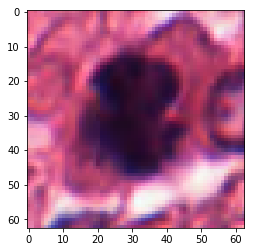

In [10]:
coords_patches, patches = localize_mitosis_patches(dict_image_csv[cases_train[0]][0])
plt.imshow(patches[0])

In [11]:
def save_patches(csv_path,coords_patches,patches,target_dir, patch_size, incremental_prefix=False):
    for i in range(len(coords_patches)):
        cur_patch = Image.fromarray(patches[i])
        if (np.array(cur_patch).shape[0] != patch_size[0]) or (np.array(cur_patch).shape[1] != patch_size[1]):
            cur_patch = resize(np.array(cur_patch),(patch_size[0],patch_size[1],3),mode='reflect')
            cur_patch = Image.fromarray(np.uint8(cur_patch*255))
            #cur_patch = Image.fromarray(patch_size,resample=Image.LANCZOS)
        num_img = csv_path.split('/')[-2]
        num_csv = csv_path.split('/')[-1].split('.csv')[0]
        coord_x, coord_y = str(coords_patches[i][0]),  str(coords_patches[i][1])
        name_patch = num_img +'_' +num_csv + '_' + coord_x + '_' +  coord_y + '.png' 
        cur_patch.save(target_dir+name_patch)
    return

In [12]:
dict_image_csv.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73])

In [13]:
#Here you needed to change the target dir for train/val/test accordingly 
target_dir = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/lafrange/val/mitosis/'
for sampl_idx_case in range(len(cases_val)):
    cur_case_name = cases_val[sampl_idx_case]
    for csv_num in range(len(dict_image_csv[cur_case_name])):
        csv_path = dict_image_csv[cur_case_name][csv_num]
        coords_patches, patches = localize_mitosis_patches(csv_path)
        print("Saving Patches for " + str(csv_path))
        save_patches(csv_path,coords_patches,patches,target_dir,patch_size=(63,63))

Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/03/01.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/03/01.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/03/02.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/03/02.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/03/03.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/03/03.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/03/04.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/03/04.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/03/05.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_gro

Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/07/22.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/07/22.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/07/23.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/07/23.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/07/24.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/07/24.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/07/25.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/07/25.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/07/26.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_gro

In [14]:
#This problem has an important class imbalance. with this function ALL of the negatives (non-overlapped) will be extracted
# for later perform hard negative mining 
def extract_neg_patches(img,coord_positive,stride_x,stride_y, min_distance):
    neg_patches, neg_patches_coords = [],[]
    #coord_positive #= coord_positive
    possible_coord, tpx,tpy = compute_corner_patches([np.array(img).shape[0],np.array(img).shape[1]],stride_x,stride_y) 
    possible_coord = possible_coord.reshape(possible_coord.shape[0]*possible_coord.shape[1],2)
    for i in range(len(possible_coord)):
        valid_negative = True
        for j in range(len(coord_positive)):
            if np.linalg.norm(np.array(possible_coord[i])-np.array(coord_positive[j])) < min_distance:
                valid_negative = False     
        if valid_negative and j == len(coord_positive) -1:
            anchor_x, anchor_y = possible_coord[i][0]-31,  possible_coord[i][1]-31
            if anchor_x < 0:  
                anchor_x = 0
            if anchor_y < 0:
                anchor_y = 0
            neg_patches_coords.append([anchor_x, anchor_y])
            neg_patches.append(np.array(img)[anchor_x:anchor_x+63,anchor_y:anchor_y+63,:])
    return neg_patches, neg_patches_coords

In [15]:
#Same as before here is only needed to change the target dir for train/val accordingly 
stride_x,stride_y,min_distance = 63,63,63
target_dir = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/lafrange/val/non_mitosis/' #Or train accordingly
coord_positive = []
for sampl_idx_case in range(len(cases_val)): #or cases_trainng accordingly
    cur_case_name =cases_test[sampl_idx_case]
    agg_coord_positive = []
    for csv_num in range(len(dict_image_csv[cur_case_name])):
        pathcsv = dict_image_csv[cur_case_name][csv_num]
        coord_positive, _, sampl_img= localize_mitosis_patches(pathcsv,return_img=True)
        neg_patches, neg_patches_coords = extract_neg_patches(sampl_img,coord_positive,stride_x,stride_y, min_distance)
        save_patches(pathcsv,neg_patches_coords,neg_patches,target_dir,patch_size=(63,63))
        #save_patches(csv_path,coords_patches,patches,target_dir,patch_size=(63,63))

Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/13/06.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/13/09.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/14/01.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/14/02.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/14/03.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/14/04.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/14/05.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/14/06.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/14/07.tif
C

Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_2/16/10.tif


In [16]:
print(cases_train)
print(cases_val)
print(cases_test)

[1, 2, 4, 6, 8, 9, 11, 12]
[3, 5, 7, 10]
[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [17]:
#Definition of the CNN model
kernel_size = (4,4)
input_shape = (63,63,3)
nb_filters = 16 
pool_size = 2
def mitosis_model(lr,clip_norm):
    model_mitosis = Sequential() #Is sequential because all the 
    #Block 0
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),
                            padding='valid',
                            input_shape=input_shape))
    model_mitosis.add(Activation('relu'))
    #Block 1
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),activation='relu'))
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('relu'))
    model_mitosis.add(MaxPooling2D(pool_size=pool_size))
    model_mitosis.add(Dropout(0.25))
    #Block 2
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),activation='relu'))
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('relu'))
    model_mitosis.add(MaxPooling2D(pool_size=pool_size))
    model_mitosis.add(Dropout(0.25))
    #Block 3
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),activation='relu'))
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('relu'))
    model_mitosis.add(MaxPooling2D(pool_size=pool_size))
    model_mitosis.add(Dropout(0.25))
    model_mitosis.add(Flatten())
    #Block 4
    model_mitosis.add(Dense(128))#, activation= 'relu')
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('softmax'))
    model_mitosis.add(Dropout(0.25))
    model_mitosis.add(Dense(2,activation='softmax'))

    #Defining the optimizer
    sgd_opt = SGD(lr=lr, momentum=0.9, decay=0.9, nesterov=True)

    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1,decay=0.9)
    else:
        adam_opt = Adam(lr)

    model_mitosis.compile(loss='categorical_crossentropy',
              optimizer=adam_opt ,
              metrics=['mae','acc'])
    return model_mitosis

Building generator for patches in /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/lafrange/training/
(32, 63, 63, 3)
(32, 2)


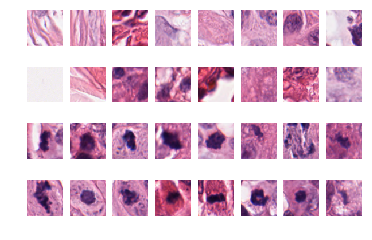

In [18]:
##Building the generators for balanced negative-positive batches

class simplePatchGenerator(object):
    def __init__(self, input_dir, batch_size, img_shape = (63,63,3), augmentation_fn=None):
        print("Building generator for patches in " + input_dir)
        # Params
        self.input_dir = input_dir  # path to patches in glob format
        self.batch_size = batch_size  # number of patches per batch
        self.augmentation_fn = augmentation_fn  # augmentation function
        self.img_shape = img_shape
        self.list_positive = glob.glob(input_dir + 'mitosis/*.png')
        self.list_negative = glob.glob(input_dir + 'non_mitosis/*.png')
        self.encoder = OneHotEncoder(sparse=False)
        

        self.n_samples = len(self.list_negative +self.list_positive)
        self.n_batches = self.n_samples // self.batch_size
    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches

    def next(self):
        # Build a mini-batch
        paths_negatives = random.sample(self.list_negative,self.batch_size//2) #self.df.loc[self.df['label'] == 0, :].sample(self.batch_size//2, replace = True)
        paths_positives = random.sample(self.list_positive,self.batch_size//2) #self.df.loc[self.df['label'] == 0, :].sample(self.batch_size//2, replace = True)
        images = []
        labels = np.concatenate((np.zeros((self.batch_size//2,1)), np.ones((self.batch_size//2,1))),axis=0)
        label_idx = 0
        for pathimg in paths_negatives+paths_positives:
            try:
                # Read image path
                # Read data and label
                image = load_image(pathimg)
                # Data augmentation
                if self.augmentation_fn:
                    image = self.augmentation_fn(image)

                # Append
                if image.shape != self.img_shape:
                    images.append(images[-1])
                    labels[label_idx] = labels[label_idx-1]
                else:
                    images.append(image)
                label_idx+=1
            except Exception as e:
                print('Failed reading img {idx}...'.format(idx=pathimg))
                print(e)
            label_idx += 1
            
        batch_x = np.stack(images).astype('float32')
        batch_y = np.stack(labels).astype('float32')

        return batch_x, self.encoder.fit_transform(batch_y)#batch_y

# Test the data generator
training_gen = simplePatchGenerator(
    input_dir='/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/lafrange/training/', 
    batch_size=32,
    img_shape = (63,63,3)
)

for batch_x, batch_y in training_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x*255, images_per_row=8)
    break

Building generator for patches in /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/lafrange/val/
(32, 63, 63, 3)
(32, 2)


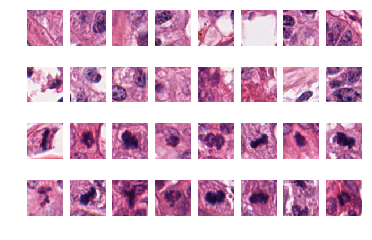

In [19]:
val_gen = simplePatchGenerator(
    input_dir='/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/lafrange/val/', 
    batch_size=32,
    img_shape = (63,63,3)
)
for batch_x, batch_y in val_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x*255, images_per_row=8)
    break
#batch_y

In [20]:
#Defining the CallBacks for tensorboard visualization and for earlystopping of the model
checkpointer = ModelCheckpoint(filepath='/home/sebastian/local_experiments/staining/models/initial_classifier/decay_skL_softmax_ADAM_weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=False)
tb_callback = TensorBoard(log_dir='/home/sebastian/local_experiments/staining/logs/skl_softmax', histogram_freq=0, batch_size=64, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

### Initial CNN model Training (using all non-overlaping negative patches)

In [337]:
#If you DO NOT need to train the model again, skip to the next cell, I've uploaded the best model to github as well
batch_size = 64
lambda_m = 0.1
epoch_size = 4000
Tp_min, Fp_max = 400, 100
model_mitosis = mitosis_model(lambda_m,True)
model_mitosis.load_weights(path_model_weights)

# 1) Sampling a stratified batch of pos and neg samples
# 2) Check time of inference for hns
max_epochs = 10
#for i in range(max_epochs):
#    #Train patch detector on one epoch;
model_mitosis.fit_generator(training_gen, epochs=max_epochs,verbose=1,callbacks=[checkpointer,tb_callback], validation_data=val_gen, validation_steps=20,steps_per_epoch=2000)

Epoch 1/10
2000/2000 [==============================] - 85s 42ms/step - loss: 0.2875 - mean_absolute_error: 0.0383 - acc: 0.9695 - val_loss: 1.1085 - val_mean_absolute_error: 0.1050 - val_acc: 0.8891

Epoch 00001: saving model to /home/sebastian/local_experiments/staining/models/initial_classifier/decay_skL_softmax_ADAM_weights.01-1.11.hdf5
Epoch 2/10
2000/2000 [==============================] - 82s 41ms/step - loss: 0.2892 - mean_absolute_error: 0.0382 - acc: 0.9696 - val_loss: 0.9015 - val_mean_absolute_error: 0.0910 - val_acc: 0.9172

Epoch 00002: saving model to /home/sebastian/local_experiments/staining/models/initial_classifier/decay_skL_softmax_ADAM_weights.02-0.90.hdf5
Epoch 3/10
2000/2000 [==============================] - 78s 39ms/step - loss: 0.2915 - mean_absolute_error: 0.0373 - acc: 0.9698 - val_loss: 1.0050 - val_mean_absolute_error: 0.1057 - val_acc: 0.9031

Epoch 00003: saving model to /home/sebastian/local_experiments/staining/models/initial_classifier/decay_skL_softm

In [21]:
lambda_m = 0.1

model_mitosis = mitosis_model(lambda_m,True)
#Loading the besto of the initial classifiers trained on all negative samples 
path_model_weights = '/home/sebastian/local_experiments/staining/models/best_models/tupac/initialClassifier_decay_skL_softmax_ADAM_weights.09-0.77.hdf5'
model_mitosis.load_weights(path_model_weights)   


InternalError: Failed to create session.

In [93]:
#The path should be changed according to the ppartition being processed, i.e., training/val/test
path_train_images_neg = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/lafrange/test/non_mitosis/'
train_images_neg = glob.glob(path_train_images_neg + '**.png')
test_batches_paths = [list_test_imgs[i:i+64] for i in range(0,len(list_test_imgs),64)]


In [95]:
#Is not a typo is just patches batches => pathches
train_pathches_neg = [train_images_neg[i:i+64] for i in range(0,len(train_images_neg),64)]
print(len(train_pathches_neg))
print(len(train_pathches_neg)*64)

4183
267712


In [81]:
#Building the hns dataset
total_fp  = 0 
probabilites = []
for batch in train_pathches_neg:
    images_batch = []
    for pathimg in batch:
        image = load_image(pathimg)
        images_batch.append(image)    
    probabilites.append(model_mitosis.predict_proba(np.array(images_batch)))
    #print(model_mitosis.predict_classes(np.array(test_batches_paths[0])))
print(len(probabilites))

4183


In [82]:
concat_probs = np.array([j for i in probabilites for j in i])
len(concat_probs)

267672

In [83]:
#Ranking the predictions on all the negative samples to obtain the hard negatives
idx_hni = np.nonzero(concat_probs[:,1]>np.mean(concat_probs[:,1]))[0]
print(idx_hni.shape)
idx_hni

(13747,)


array([   115,    316,    487, ..., 267351, 267489, 267575])

In [84]:
#Copying hard negative instances to a new directory
from shutil import copyfile
dst = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/lafrange/test/non_mitosis_hnm/'
for pathneg in np.array(train_images_neg)[idx_hni]:
    copyfile(pathneg, dst+pathneg.split('/')[-1])